In [1]:
plain_training_data_path = "Datasets/plain-train.json" # ini semua file path buat training sama validasi
plain_validation_data_path = "Datasets/plain-test.json"
cipher_training_data_path = "Datasets/cipher-train.json"
cipher_validation_data_path = "Datasets/cipher-test.json"

def read_files(path): # untuk membaca konten dari file yg diberikan path
    with open(path, "r", encoding="utf-8") as f:  # menggunakan fungsi open() dengan "r" mode (read)
        data_train_dataset = f.read().split("\n")[:-1] # file dibaca, lalu dibagi ke dalam barisan-barisan dengan karakter barisan baru "\n",
    return data_train_dataset                          # [:-1] untuk exclude empty lines

plain_training_data = read_files(plain_training_data_path)
plain_validation_data = read_files(plain_validation_data_path)
cipher_training_data = read_files(cipher_training_data_path)
cipher_validation_data = read_files(cipher_validation_data_path)

max_lenght = 20 # panjang kalimatnya maksimum
train_dataset = [[cipher_sentence, plain_sentence] for cipher_sentence, plain_sentence in zip(cipher_training_data, plain_training_data) if len(cipher_sentence) <= max_lenght and len(plain_sentence) <= max_lenght]
val_dataset = [[cipher_sentence, plain_sentence] for cipher_sentence, plain_sentence in zip(cipher_validation_data, plain_validation_data) if len(cipher_sentence) <= max_lenght and len(plain_sentence) <= max_lenght]
cipher_training_data, plain_training_data = zip(*train_dataset) # ini di unzip ke dalam es_train dan en_train
cipher_validation_data, plain_validation_data = zip(*val_dataset) # ini di unzip ke dalam es_val dan en_val

print(len(cipher_training_data))
print(len(cipher_validation_data))
print(cipher_training_data[:5]) # ini maksudnya mau dilihat 5 datanya apa aja
print(plain_training_data[:5])

3999
999
('#Ggu4*', '{e9?esIa', 'j6jbbL', 'C}S/&r +k', ',$V-XSX<*t')
('jongie', 'fongool2', '20995', 'ANGEL4951', 'saniblamig')


In [2]:
from customtokenizer import CustomTokenizer

# prepare Spanish tokenizer, this is the input language
tokenizer = CustomTokenizer(char_level=True)
tokenizer.fit_on_texts(cipher_training_data)
tokenizer.save("c_tokenizer.json")

# prepare English tokenizer, this is the output language
detokenizer = CustomTokenizer(char_level=True)
detokenizer.fit_on_texts(plain_training_data)  # kenapa yang ini didetokenize padahal belum di tokenize??? ternyata cuma namanya aja, tapi
                                            # tetap tokenizing bukan detokenizer
detokenizer.save("p_tokenizer.json")

Fitting tokenizer: 100%|██████████| 3999/3999 [00:00<00:00, 1211135.94it/s]


In [3]:
from mltu.tensorflow.dataProvider import DataProvider # install dulu mltu modulnya
import numpy as np

def preprocess_inputs(data_batch, label_batch):
    encoder_input = np.zeros((len(data_batch), tokenizer.max_length)).astype(np.int64)
    decoder_input = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)
    decoder_output = np.zeros((len(label_batch), detokenizer.max_length)).astype(np.int64)

    data_batch_tokens = tokenizer.texts_to_sequences(data_batch)
    label_batch_tokens = detokenizer.texts_to_sequences(label_batch)

    for index, (data, label) in enumerate(zip(data_batch_tokens, label_batch_tokens)):
        encoder_input[index][:len(data)] = data
        decoder_input[index][:len(label)-1] = label[:-1] # Drop the [END] tokens
        decoder_output[index][:len(label)-1] = label[1:] # Drop the [START] tokens

    return (encoder_input, decoder_input), decoder_output

train_dataProvider = DataProvider(
    train_dataset, 
    batch_size=4, 
    batch_postprocessors=[preprocess_inputs],
    use_cache=True
    )

val_dataProvider = DataProvider(
    val_dataset, 
    batch_size=4, 
    batch_postprocessors=[preprocess_inputs],
    use_cache=True
    )

In [4]:
import tensorflow as tf
from encoder import Encoder
from decoder import Decoder

def Transformer(
    input_vocab_size: int, 
    target_vocab_size: int, 
    encoder_input_size: int = None,
    decoder_input_size: int = None,
    num_layers: int=6, 
    d_model: int=512, 
    num_heads: int=8,
    dff: int=2048,
    dropout_rate: float=0.1,
    ) -> tf.keras.Model:
    """
    A custom TensorFlow model that implements the Transformer architecture.

    Args:
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        encoder_input_size (int): The size of the encoder input sequence.
        decoder_input_size (int): The size of the decoder input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of heads in the multi-head attention layer.
        dff (int): The dimensionality of the feed-forward layer.
        dropout_rate (float): The dropout rate.

    Returns:
        A TensorFlow Keras model.
    """
    inputs = [
        tf.keras.layers.Input(shape=(encoder_input_size,), dtype=tf.int64), 
        tf.keras.layers.Input(shape=(decoder_input_size,), dtype=tf.int64)
        ]
    
    encoder_input, decoder_input = inputs

    encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(encoder_input)
    decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)(decoder_input, encoder)

    output = tf.keras.layers.Dense(target_vocab_size)(decoder)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [5]:
transformer = Transformer(
    num_layers=2,
    d_model=128,
    num_heads=8,
    dff=512,
    input_vocab_size=len(tokenizer)+1,
    target_vocab_size=len(detokenizer)+1,
    dropout_rate=0.1,
    encoder_input_size=tokenizer.max_length,
    decoder_input_size=detokenizer.max_length
    )

transformer.summary()

C:\Users\ACER VERITON Z4\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\ACER VERITON Z4\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\ACER VERITON Z4\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support ma

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder (Encoder)   │ (None, 22, 128)   │  1,328,640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (Decoder)   │ (None, 22, 128)   │  2,383,232 │ input_layer_1[0]… │
│                     │                   │            │ encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 22, 65)    │      8,385 │ decoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,720,257 (14.19 MB)

 Trainable params: 3,720,257 (14.19 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.optimizers import Adam
from mltu.tensorflow.transformer.utils import MaskedAccuracy, MaskedLoss

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
transformer.compile(optimizer=optimizer,
                    loss=MaskedLoss(),
                    metrics=[MaskedAccuracy()],
                    run_eagerly=False)

In [7]:
#pip install tf2onnx

In [8]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="tb_callback_dir", histogram_freq=1)

# Train the model
history = transformer.fit(
    train_dataProvider,
    epochs=200,
    validation_data=val_dataProvider
    #callbacks=[warmupCosineDecay, checkpoint, tb_callback, reduceLROnPlat,model2onnx,encDecSplitCallback]
    )

Epoch 1/200


C:\Users\ACER VERITON Z4\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - loss: 2.9953 - masked_accuracy: 0.1868 - val_loss: 2.7543 - val_masked_accuracy: 0.2073
Epoch 2/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 2.7522 - masked_accuracy: 0.2129 - val_loss: 2.6860 - val_masked_accuracy: 0.2245
Epoch 3/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - loss: 2.7007 - masked_accuracy: 0.2228 - val_loss: 2.6536 - val_masked_accuracy: 0.2275
Epoch 4/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - loss: 2.6658 - masked_accuracy: 0.2280 - val_loss: 2.6348 - val_masked_accuracy: 0.2278
Epoch 5/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 2.6295 - masked_accuracy: 0.2363 - val_loss: 2.6115 - val_masked_accuracy: 0.2373
Epoch 6/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - loss: 2.5946 - masked_accuracy: 0.2476 - val_loss: 2.5946 - val_masked_accuracy: 0.2436
Epoch 7/200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 72ms/step - loss: 2.5494 - masked_accuracy: 0.2597 - val_loss: 2.5562 - val_masked_

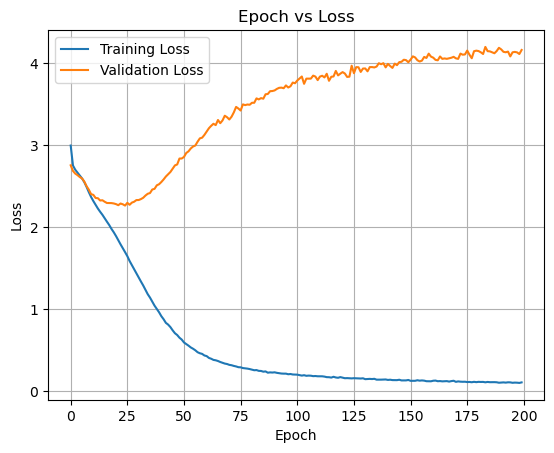

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

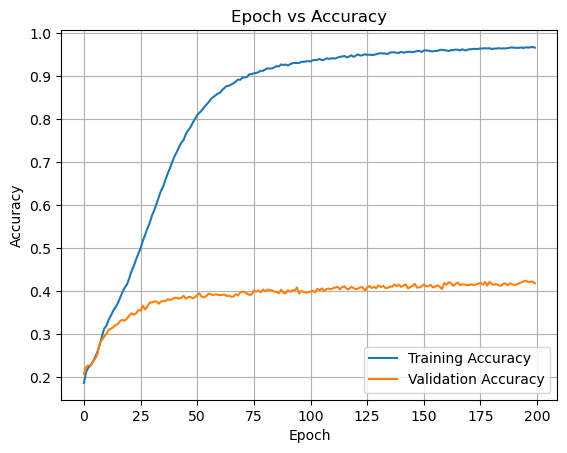

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['masked_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
#from datetime import datetime
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
#from mltu.tensorflow.callbacks import Model2onnx, WarmupCosineDecay
#from mltu.tensorflow.transformer.callbacks import EncDecSplitCallback
#import os

#model_path = os.path.join(
            "Models/09_translation_transformer",
            datetime.strftime(datetime.now(), "%Y%m%d%H%M"),
        )

# Define callbacks
#warmupCosineDecay = WarmupCosineDecay(
#    lr_after_warmup=0.005,
#    final_lr=0.001,
#    warmup_epochs=2,
#    decay_epochs=18,
#    initial_lr=0.0001,
#    )
#earlystopper = EarlyStopping(monitor="val_masked_accuracy", patience=5, verbose=1, mode="max")
#checkpoint = ModelCheckpoint(f"{model_path}/model.keras", monitor="val_masked_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=False)
#tb_callback = TensorBoard(f"{model_path}/logs")
#reduceLROnPlat = ReduceLROnPlateau(monitor="val_masked_accuracy", factor=0.9, min_delta=1e-10, patience=2, verbose=1, mode="max")
#model2onnx = Model2onnx(f"{model_path}/model.keras", metadata={"tokenizer": tokenizer.dict(), "detokenizer": detokenizer.dict()}, save_on_epoch_end=False)
#encDecSplitCallback = EncDecSplitCallback(model_path, encoder_metadata={"tokenizer": tokenizer.dict()}, decoder_metadata={"detokenizer": detokenizer.dict()})

IndentationError: unindent does not match any outer indentation level (<string>, line 10)